# Code Used in Final Project for Determining Ideal Locations for New Restaurants in Detroit Metropolitan Area
## Author: Neil Gurram

## Installing Packages

In [154]:
!pip install requests
!pip install beautifulsoup4
!pip install -U notebook-as-pdf
!pip install pyppeteer
!pip install geopy
!pip install folium

Requirement already up-to-date: notebook-as-pdf in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (0.0.2)


## Importing Packages

In [155]:
from bs4 import BeautifulSoup 

from geopy.geocoders import Nominatim# convert an address into latitude and longitude values

import numpy as np# library to handle data in a vectorized manner

import pandas as pd# library for data analsysis
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 10)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

## Getting the cities in Detroit Metropolitan Area (DMA) by webscraping from geographic.org

In [156]:
def get_cities(county_name):##This method assumes the county_name is in Michigan, and that the list of cities is part of an unordered list tag. 
    cities = []
    url = "https://geographic.org/streetview/usa/mi/"+county_name.lower()+"/index.html"
    #open with GET method 
    resp=requests.get(url) 
      
    #http_respone 200 means OK status 
    if resp.status_code==200: 
      
        # we need a parser,Python built-in HTML parser is enough . 
        soup=BeautifulSoup(resp.text,'html.parser')     
  
        # l is the list which contains all the cities
        l=soup.find("ul") 
      
        #Find all the elements of a, i.e anchor. This happens to correspond to the cities listed.
        for i in l.findAll("a"): 
            cities.append(i.text) 
    return cities

def get_all_cities(county_list):##This method returns a list of lists of city and county
    cities = []
    for county in county_list:
        for city in get_cities(county):
            cities.append((city,county))
    return cities

## Creating location dataframe from all cities in the Macomb, Oakland, and Wayne Counties

In [157]:
dma_tuples = get_all_cities(["Macomb","Oakland","Wayne"])

def create_location_dataframe(city_tuples):##Assumes we have a city,county tuple pair from Michigan
    location_dataframe = []
    geolocator = Nominatim(user_agent="detroit_explorer")
    for city,county in city_tuples:
        city_augmented = city+", MI"
        coordinates = geolocator.geocode(city_augmented)
        latitude = coordinates.latitude
        longitude = coordinates.longitude
        location_dataframe.append([city.title(),county.title(),latitude,longitude])
    location_dataframe = pd.DataFrame(location_dataframe,columns=["City","County","City Latitude","City Longitude"])
    return location_dataframe
dma_dataframe = create_location_dataframe(dma_tuples)

## Filtering all the data to ensure we have correct latitude and longitudes

In [158]:
dma_dataframe = dma_dataframe[(dma_dataframe["City Latitude"]>=41) & (dma_dataframe["City Latitude"] <= 43) 
                              & (dma_dataframe["City Longitude"]>=-84) & (dma_dataframe["City Longitude"]<=-82)]

In [159]:
dma_dataframe.reset_index(drop=True,inplace=True)
dma_dataframe

,City,County,City Latitude,City Longitude
0,Armada,Macomb,42.844196,-82.884372
1,Center Line,Macomb,42.485036,-83.027700
2,Clinton Township,Macomb,42.584852,-82.934824
3,Eastpointe,Macomb,42.468370,-82.955475
4,Fraser,Macomb,42.539202,-82.949365
...,...,...,...,...
53,Romulus,Wayne,42.222261,-83.396599
54,Southgate,Wayne,42.203710,-83.206756
55,Wayne,Wayne,42.268241,-83.284417
56,Westland,Wayne,42.323806,-83.400532


## Using Foursquare to get Venues from DMA

In [160]:
# @hidden_cell
CLIENT_ID = '1N0NN5RFG2UBFYZMIOPR2GFAJDMNNK3LUNJLKXURFQ3Z1Q3Q' # your Foursquare ID
CLIENT_SECRET = '2JV2C3OK3HNACGHQ53EBPSULYYF14M5Y3NFKFV3XZ0MYTTTO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # A default Foursquare API limit value

In [161]:
def getNearbyVenues(cities, counties, city_latitudes, city_longitudes, radius=1610):
    
    venues_list=[]
    for city, county, city_latitude, city_longitude in zip(cities, counties, city_latitudes,city_longitudes):
        ##print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            city_latitude, 
            city_longitude, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            county,
            city_latitude, 
            city_longitude, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 'County','City Latitude', 'City Longitude', 
                  'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [162]:
dma_venues = getNearbyVenues(cities=dma_dataframe['City'],
                             counties=dma_dataframe['County'],
                             city_latitudes=dma_dataframe['City Latitude'],
                             city_longitudes=dma_dataframe['City Longitude']
                            )
dma_venues

,City,County,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Armada,Macomb,42.844196,-82.884372,Papa's,42.844017,-82.884001,Restaurant
1,Armada,Macomb,42.844196,-82.884372,SUBWAY,42.844247,-82.884455,Sandwich Place
2,Armada,Macomb,42.844196,-82.884372,Achatz Handmade Pie Co.,42.854847,-82.884699,Bakery
3,Armada,Macomb,42.844196,-82.884372,Tivoli's Pizza,42.844254,-82.883684,Pizza Place
4,Armada,Macomb,42.844196,-82.884372,Chap's Food & Spirits,42.844008,-82.883720,Restaurant
...,...,...,...,...,...,...,...,...
2727,Wyandotte,Wayne,42.200662,-83.151016,Vinewood Mexican Bakery,42.207565,-83.164956,Bakery
2728,Wyandotte,Wayne,42.200662,-83.151016,Joe's Corner Store,42.201436,-83.168071,Convenience Store
2729,Wyandotte,Wayne,42.200662,-83.151016,Kielbasa Joe’s,42.204145,-83.167687,Butcher
2730,Wyandotte,Wayne,42.200662,-83.151016,Cahalan Liquor & Party Store,42.199967,-83.168691,Liquor Store


## Getting unique venue categories

In [163]:
unique_venue_categories=list(dma_venues['Venue Category'].unique())
unique_venue_categories.sort()
unique_venue_categories

['Accessories Store',
 'Adult Boutique',
 'Airport',
 'Airport Service',
 'American Restaurant',
 'Arcade',
 'Art Gallery',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Dealership',
 'Auto Garage',
 'Auto Workshop',
 'Automotive Shop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Bay',
 'Beach',
 'Beer Bar',
 'Beer Garden',
 'Beer Store',
 'Big Box Store',
 'Bike Shop',
 'Bike Trail',
 'Bistro',
 'Board Shop',
 'Boat Launch',
 'Bookstore',
 'Boutique',
 'Bowling Alley',
 'Breakfast Spot',
 'Brewery',
 'Bubble Tea Shop',
 'Buffet',
 'Building',
 'Burger Joint',
 'Business Service',
 'Butcher',
 'Café',
 'Cajun / Creole Restaurant',
 'Campground',
 'Candy Store',
 'Car Wash',
 'Casino',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'Comedy Club',
 'Comic Shop',
 'Concert Hall',
 'Const

In [164]:
print("There are ", len(unique_venue_categories), " categories.")

There are  292  categories.


## List of Restaurant Venue Categories

In [165]:
restaurant_venue_categories = set(['American Restaurant','Asian Restaurant','BBQ Joint','Beer Garden',
                                  'Bistro','Breakfast Spot','Buffet','Burger Joint','Café','Cajun / Creole Restaurant',
                                  'Chinese Restaurant', 'Cuban Restaurant','Deli / Bodega','Diner',
                                  'Eastern European Restaurant','Ethiopian Restaurant','Falafel Restaurant','Fast Food Restaurant','Food',
                                  'Food & Drink Shop','Food Truck','French Restaurant','Fried Chicken Joint','Gluten-free Restaurant',
                                  'Greek Restaurant','Hot Dog Joint','Hungarian Restaurant','Indian Restaurant','Irish Pub',
                                  'Italian Restaurant','Japanese Restaurant','Korean Restaurant','Latin American Restaurant','Mediterranean Restaurant',
                                  'Mexican Restaurant','Middle Eastern Restaurant','Mongolian Restaurant','New American Restaurant','Noodle House',
                                  'Pizza Place','Polish Restaurant','Restaurant','Salad Place','Sandwich Place',
                                  'Seafood Restaurant','Snack Place','Soup Place','Steakhouse',
                                  'Sushi Restaurant','Taco Place','Tex-Mex Restaurant','Thai Restaurant','Theme Restaurant',
                                  'Vegetarian / Vegan Restaurant','Vietnamese Restaurant','Wings Joint','Yemeni Restaurant'])

In [166]:
print("There are ", len(restaurant_venue_categories), "categories pertaining to restaurants.")

There are  57 categories pertaining to restaurants.


In [167]:
## Checking any spelling errors
for restaurant_category in restaurant_venue_categories:
    total = sum(dma_venues['Venue Category'] == restaurant_category)
    if total == 0:
        print(restaurant_category)

## Filtering to Keep Only Restaurant Venues

In [168]:
dma_restaurant_venues = dma_venues[dma_venues['Venue Category'].isin(restaurant_venue_categories)]
dma_restaurant_venues.groupby(['County','Venue','Venue Latitude','Venue Longitude']).ngroups
dma_restaurant_venues.reset_index(drop=True,inplace=True)
dma_restaurant_venues

,City,County,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Armada,Macomb,42.844196,-82.884372,Papa's,42.844017,-82.884001,Restaurant
1,Armada,Macomb,42.844196,-82.884372,SUBWAY,42.844247,-82.884455,Sandwich Place
2,Armada,Macomb,42.844196,-82.884372,Tivoli's Pizza,42.844254,-82.883684,Pizza Place
3,Armada,Macomb,42.844196,-82.884372,Chap's Food & Spirits,42.844008,-82.883720,Restaurant
4,Center Line,Macomb,42.485036,-83.027700,Pauluke's Grill,42.482994,-83.027071,American Restaurant
...,...,...,...,...,...,...,...,...
978,Wyandotte,Wayne,42.200662,-83.151016,SUBWAY,42.209797,-83.147658,Sandwich Place
979,Wyandotte,Wayne,42.200662,-83.151016,Big Boy Restaurant,42.199199,-83.151626,American Restaurant
980,Wyandotte,Wayne,42.200662,-83.151016,Wendy’s,42.198147,-83.152044,Fast Food Restaurant
981,Wyandotte,Wayne,42.200662,-83.151016,McDonald's,42.198504,-83.150767,Fast Food Restaurant


## Getting Number of Cities per County

[]

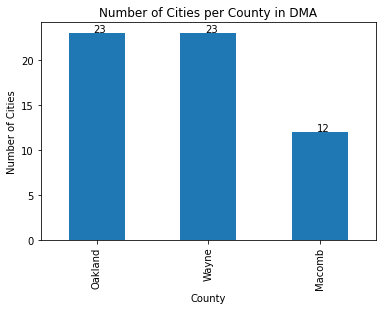

In [169]:
county_axes = pd.value_counts(dma_dataframe['County']).plot(kind="bar")
county_axes.set(xlabel="County",ylabel="Number of Cities",title="Number of Cities per County in DMA")
x_offset = -0.03
y_offset = 0.02
##To put the frequency on top of the bars
for p in county_axes.patches:
    b = p.get_bbox()
    val = b.y1 + b.y0        
    county_axes.annotate(int(val), ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
county_axes.plot()

## Using Folium to Get a Map of Cities by County

In [170]:
center_coordinates = list(dma_dataframe[['City Latitude','City Longitude']].mean())
center_coordinates
map_clusters = folium.Map(location=center_coordinates, zoom_start=9)
counties = ['Oakland','Wayne','Macomb']
numCounties = len(counties)
x = np.arange(numCounties)
ys = [i + x + (i*x)**2 for i in range(numCounties)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
def county_index(county):
    return counties.index(county)
for city_latitude, city_longitude, city, county in zip(dma_dataframe['City Latitude'], dma_dataframe['City Longitude'], 
                                                       dma_dataframe['City'], dma_dataframe['County']):
    label = folium.Popup(str(city) + ' County ' + str(county), parse_html=True)
    countyIndex = county_index(county)
    folium.CircleMarker(
        [city_latitude, city_longitude],
        radius=5,
        popup=label,
        color=rainbow[countyIndex],
        fill=True,
        fill_color=rainbow[countyIndex],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## One-Hot Encoding of Venue Categories in Unfiltered Data

In [171]:
dma_venues_onehot = pd.get_dummies(dma_venues[['Venue Category']], prefix="", prefix_sep="")
dma_venues_concat_onehot = pd.concat([dma_venues,dma_venues_onehot],axis=1)
dma_venues_concat_onehot

,City,County,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,...,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Armada,Macomb,42.844196,-82.884372,Papa's,42.844017,-82.884001,...,0,0,0,0,0,0,0
1,Armada,Macomb,42.844196,-82.884372,SUBWAY,42.844247,-82.884455,...,0,0,0,0,0,0,0
2,Armada,Macomb,42.844196,-82.884372,Achatz Handmade Pie Co.,42.854847,-82.884699,...,0,0,0,0,0,0,0
3,Armada,Macomb,42.844196,-82.884372,Tivoli's Pizza,42.844254,-82.883684,...,0,0,0,0,0,0,0
4,Armada,Macomb,42.844196,-82.884372,Chap's Food & Spirits,42.844008,-82.883720,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,Wyandotte,Wayne,42.200662,-83.151016,Vinewood Mexican Bakery,42.207565,-83.164956,...,0,0,0,0,0,0,0
2728,Wyandotte,Wayne,42.200662,-83.151016,Joe's Corner Store,42.201436,-83.168071,...,0,0,0,0,0,0,0
2729,Wyandotte,Wayne,42.200662,-83.151016,Kielbasa Joe’s,42.204145,-83.167687,...,0,0,0,0,0,0,0
2730,Wyandotte,Wayne,42.200662,-83.151016,Cahalan Liquor & Party Store,42.199967,-83.168691,...,0,0,0,0,0,0,0


## Getting Proportion of Venue Categories within each City (Unfiltered Proportion Dataframe)

In [172]:
dma_venues_concat_onehot_grouped = dma_venues_concat_onehot.groupby(['City','County']).mean().reset_index()
dma_venues_concat_onehot_grouped.drop(columns=['City Latitude','City Longitude','Venue Latitude','Venue Longitude'],inplace=True)
dma_venues_concat_onehot_grouped

,City,County,Accessories Store,Adult Boutique,Airport,Airport Service,American Restaurant,...,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Allen Park,Wayne,0.0,0.000000,0.0,0.0,0.086957,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,Armada,Macomb,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,Auburn Hills,Oakland,0.0,0.000000,0.0,0.0,0.090909,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bloomfield Hills,Oakland,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,Center Line,Macomb,0.0,0.000000,0.0,0.0,0.054545,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,Walled Lake,Oakland,0.0,0.000000,0.0,0.0,0.025641,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
54,Wayne,Wayne,0.0,0.021277,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
55,Westland,Wayne,0.0,0.000000,0.0,0.0,0.015625,...,0.0,0.015625,0.0,0.0,0.0,0.0,0.0
56,Wixom,Oakland,0.0,0.000000,0.0,0.0,0.024390,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## Getting Top Ten Venue Categories within each City (Unfiltered Top Ten Dataframe)

In [173]:
ONE_HOT_START_INDEX = 2##As the dataframe only starts with the one-hot columns at index 2
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[ONE_HOT_START_INDEX:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City','County']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

top_ten_dma_venues = pd.DataFrame(columns=columns)
top_ten_dma_venues[['City','County']] = dma_venues_concat_onehot_grouped[['City','County']]

for ind in np.arange(dma_venues_concat_onehot_grouped.shape[0]):
    top_ten_dma_venues.iloc[ind, ONE_HOT_START_INDEX:] = return_most_common_venues(dma_venues_concat_onehot_grouped.iloc[ind, :], num_top_venues)

top_ten_dma_venues

,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allen Park,Wayne,American Restaurant,Pizza Place,Fast Food Restaurant,Taco Place,Italian Restaurant,Bank,Pharmacy,Discount Store,Diner,Deli / Bodega
1,Armada,Macomb,Restaurant,Bar,Sandwich Place,Hardware Store,Ice Cream Shop,Bakery,Pizza Place,Trail,Farmers Market,Fast Food Restaurant
2,Auburn Hills,Oakland,Pizza Place,American Restaurant,Chinese Restaurant,Intersection,Thai Restaurant,Sports Bar,Mexican Restaurant,Mobile Phone Shop,Brewery,Frozen Yogurt Shop
3,Bloomfield Hills,Oakland,Hotel,Bank,Bagel Shop,Construction & Landscaping,Greek Restaurant,Spa,Seafood Restaurant,Deli / Bodega,Intersection,Science Museum
4,Center Line,Macomb,Park,Intersection,American Restaurant,Bar,Ice Cream Shop,Discount Store,Diner,Pharmacy,Dessert Shop,Liquor Store
...,...,...,...,...,...,...,...,...,...,...,...,...
53,Walled Lake,Oakland,Fast Food Restaurant,Sandwich Place,Bar,Bowling Alley,Toy / Game Store,Beach,Cosmetics Shop,Gym / Fitness Center,Grocery Store,Ice Cream Shop
54,Wayne,Wayne,Pizza Place,Fast Food Restaurant,Pharmacy,Grocery Store,Liquor Store,Hardware Store,Video Store,Bakery,Ice Cream Shop,Convenience Store
55,Westland,Wayne,Coffee Shop,Pizza Place,Mexican Restaurant,Discount Store,Diner,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Liquor Store,Video Game Store
56,Wixom,Oakland,Pizza Place,Sandwich Place,Park,Gym / Fitness Center,Bank,Restaurant,Post Office,Brewery,Soccer Field,Skating Rink


## One-Hot Encoding of Venue Categories in Filtered Data

In [174]:
dma_restaurant_venues_onehot = pd.get_dummies(dma_restaurant_venues[['Venue Category']], prefix="", prefix_sep="")
dma_restaurant_venues_concat_onehot = pd.concat([dma_restaurant_venues,dma_restaurant_venues_onehot],axis=1)
dma_restaurant_venues_concat_onehot

,City,County,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,...,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
0,Armada,Macomb,42.844196,-82.884372,Papa's,42.844017,-82.884001,...,0,0,0,0,0,0,0
1,Armada,Macomb,42.844196,-82.884372,SUBWAY,42.844247,-82.884455,...,0,0,0,0,0,0,0
2,Armada,Macomb,42.844196,-82.884372,Tivoli's Pizza,42.844254,-82.883684,...,0,0,0,0,0,0,0
3,Armada,Macomb,42.844196,-82.884372,Chap's Food & Spirits,42.844008,-82.883720,...,0,0,0,0,0,0,0
4,Center Line,Macomb,42.485036,-83.027700,Pauluke's Grill,42.482994,-83.027071,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,Wyandotte,Wayne,42.200662,-83.151016,SUBWAY,42.209797,-83.147658,...,0,0,0,0,0,0,0
979,Wyandotte,Wayne,42.200662,-83.151016,Big Boy Restaurant,42.199199,-83.151626,...,0,0,0,0,0,0,0
980,Wyandotte,Wayne,42.200662,-83.151016,Wendy’s,42.198147,-83.152044,...,0,0,0,0,0,0,0
981,Wyandotte,Wayne,42.200662,-83.151016,McDonald's,42.198504,-83.150767,...,0,0,0,0,0,0,0


## Getting Proportion of Venue Categories within each City (Filtered Proportion Dataframe)

In [175]:
dma_restaurant_venues_concat_onehot_grouped = dma_restaurant_venues_concat_onehot.groupby(['City','County']).mean().reset_index()
dma_restaurant_venues_concat_onehot_grouped.drop(columns=['City Latitude','City Longitude','Venue Latitude','Venue Longitude'],inplace=True)
dma_restaurant_venues_concat_onehot_grouped

,City,County,American Restaurant,Asian Restaurant,BBQ Joint,Beer Garden,Bistro,...,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
0,Allen Park,Wayne,0.166667,0.027778,0.000000,0.0,0.000000,...,0.0,0.027778,0.0,0.0,0.0,0.000000,0.0
1,Armada,Macomb,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Auburn Hills,Oakland,0.187500,0.062500,0.000000,0.0,0.000000,...,0.0,0.125000,0.0,0.0,0.0,0.000000,0.0
3,Bloomfield Hills,Oakland,0.000000,0.000000,0.000000,0.0,0.250000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,Center Line,Macomb,0.187500,0.000000,0.000000,0.0,0.000000,...,0.0,0.062500,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,Walled Lake,Oakland,0.062500,0.000000,0.062500,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
53,Wayne,Wayne,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
54,Westland,Wayne,0.034483,0.068966,0.034483,0.0,0.000000,...,0.0,0.034483,0.0,0.0,0.0,0.034483,0.0
55,Wixom,Oakland,0.052632,0.052632,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


## Getting Top Ten Venue Categories within each City (Filtered Top Ten Dataframe)

In [176]:
top_ten_dma_restaurant_venues = pd.DataFrame(columns=columns)
top_ten_dma_restaurant_venues[['City','County']] = dma_restaurant_venues_concat_onehot_grouped[['City','County']]

for ind in np.arange(dma_restaurant_venues_concat_onehot_grouped.shape[0]):
    top_ten_dma_restaurant_venues.iloc[ind, ONE_HOT_START_INDEX:] = return_most_common_venues(dma_restaurant_venues_concat_onehot_grouped.iloc[ind, :],
                                                                            num_top_venues)

top_ten_dma_restaurant_venues

,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allen Park,Wayne,American Restaurant,Pizza Place,Fast Food Restaurant,Taco Place,Italian Restaurant,Diner,Sandwich Place,Deli / Bodega,Fried Chicken Joint,Thai Restaurant
1,Armada,Macomb,Restaurant,Sandwich Place,Pizza Place,Diner,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food & Drink Shop
2,Auburn Hills,Oakland,Pizza Place,American Restaurant,Thai Restaurant,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Gluten-free Restaurant
3,Bloomfield Hills,Oakland,Deli / Bodega,Greek Restaurant,Bistro,Seafood Restaurant,Eastern European Restaurant,Hot Dog Joint,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,Food Truck
4,Center Line,Macomb,American Restaurant,Fast Food Restaurant,Pizza Place,Diner,Italian Restaurant,Thai Restaurant,Snack Place,Sandwich Place,Chinese Restaurant,Deli / Bodega
...,...,...,...,...,...,...,...,...,...,...,...,...
52,Walled Lake,Oakland,Fast Food Restaurant,Sandwich Place,American Restaurant,Sushi Restaurant,Pizza Place,Diner,Chinese Restaurant,Hot Dog Joint,Breakfast Spot,BBQ Joint
53,Wayne,Wayne,Pizza Place,Fast Food Restaurant,Diner,Sandwich Place,Restaurant,Fried Chicken Joint,Mexican Restaurant,Chinese Restaurant,Gluten-free Restaurant,French Restaurant
54,Westland,Wayne,Pizza Place,Mexican Restaurant,Diner,Asian Restaurant,Fast Food Restaurant,Sandwich Place,American Restaurant,Seafood Restaurant,Wings Joint,Mediterranean Restaurant
55,Wixom,Oakland,Pizza Place,Sandwich Place,Restaurant,American Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Diner,Taco Place,Italian Restaurant


## K-Means Clustering with Unfiltered Data and Filtered Data

In [177]:
dma_venues_concat_onehot_grouped_clustering = dma_venues_concat_onehot_grouped.drop(columns=['City','County'])
dma_restaurant_venues_concat_onehot_grouped_clustering = dma_restaurant_venues_concat_onehot_grouped.drop(columns=['City','County'])
SSE_unfiltered = []
SSE_filtered = []

for num_clusters in range(2,10):##we will go from two to nine clusters
    kmeans_unfiltered = KMeans(n_clusters=num_clusters, random_state=0).fit(dma_venues_concat_onehot_grouped_clustering)
    SSE_unfiltered.append(kmeans_unfiltered.inertia_)##gets the SSE
    kmeans_filtered= KMeans(n_clusters=num_clusters, random_state=0).fit(dma_restaurant_venues_concat_onehot_grouped_clustering)
    SSE_filtered.append(kmeans_filtered.inertia_)##gets the SSE
print(SSE_unfiltered)
print(SSE_filtered)

[1.9632404739213292, 1.8348583586589666, 1.7113691993820133, 1.6273775362511864, 1.5348301088544118, 1.471352295415695, 1.3965102449625468, 1.3260214191355733]
[4.69079433916933, 4.232835617705206, 3.8084549104825225, 3.417117729349126, 3.230825206307423, 2.9334679039305094, 2.784867681717829, 2.553090754716851]


### Elbow Plot for Unfiltered Data

In [178]:
x_numClusters = list(range(2,10))

[]

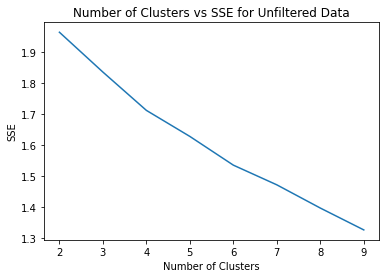

In [179]:
elbow_unfiltered_axes = plt.axes()
elbow_unfiltered_axes.plot(x_numClusters,SSE_unfiltered)
elbow_unfiltered_axes.set(xlabel="Number of Clusters",ylabel="SSE",title="Number of Clusters vs SSE for Unfiltered Data")
elbow_unfiltered_axes.plot()

### Elbow Plot for Filtered Data

[]

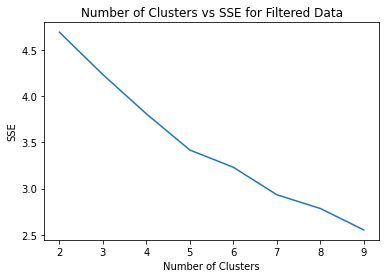

In [180]:
elbow_filtered_axes = plt.axes()
elbow_filtered_axes.plot(x_numClusters,SSE_filtered)
elbow_filtered_axes.set(xlabel="Number of Clusters",ylabel="SSE",title="Number of Clusters vs SSE for Filtered Data")
elbow_filtered_axes.plot()

### Elbow Plots for Unfiltered Data and Filtered Data

[Text(0.5, 0, 'Number of Clusters'),
 Text(0, 0.5, 'SSE'),
 Text(0.5, 1.0, 'Number of Clusters vs SSE for Filtered Data')]

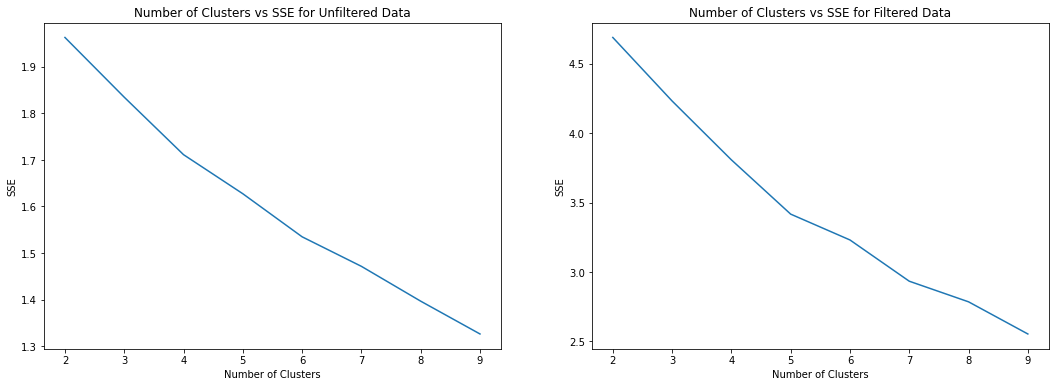

In [188]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(18,6))
axes[0].plot(x_numClusters, SSE_unfiltered)
axes[0].set(xlabel="Number of Clusters",ylabel="SSE",title="Number of Clusters vs SSE for Unfiltered Data")
axes[1].plot(x_numClusters, SSE_filtered)
axes[1].set(xlabel="Number of Clusters",ylabel="SSE",title="Number of Clusters vs SSE for Filtered Data")

## Inserting Cluster Number into Unfiltered Proportion Dataframe for Best Choice of K

In [182]:
UNFILTERED_OPTIMUM_K = 6
top_ten_dma_venues_with_cluster = top_ten_dma_venues
unfiltered_kmeans = KMeans(n_clusters=UNFILTERED_OPTIMUM_K, random_state=0).fit(dma_venues_concat_onehot_grouped_clustering)
top_ten_dma_venues_with_cluster["Cluster Number"] = pd.Series(unfiltered_kmeans.labels_)
top_ten_dma_venues_with_cluster

,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
0,Allen Park,Wayne,American Restaurant,Pizza Place,Fast Food Restaurant,Taco Place,Italian Restaurant,Bank,Pharmacy,Discount Store,Diner,Deli / Bodega,4
1,Armada,Macomb,Restaurant,Bar,Sandwich Place,Hardware Store,Ice Cream Shop,Bakery,Pizza Place,Trail,Farmers Market,Fast Food Restaurant,2
2,Auburn Hills,Oakland,Pizza Place,American Restaurant,Chinese Restaurant,Intersection,Thai Restaurant,Sports Bar,Mexican Restaurant,Mobile Phone Shop,Brewery,Frozen Yogurt Shop,3
3,Bloomfield Hills,Oakland,Hotel,Bank,Bagel Shop,Construction & Landscaping,Greek Restaurant,Spa,Seafood Restaurant,Deli / Bodega,Intersection,Science Museum,3
4,Center Line,Macomb,Park,Intersection,American Restaurant,Bar,Ice Cream Shop,Discount Store,Diner,Pharmacy,Dessert Shop,Liquor Store,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,Walled Lake,Oakland,Fast Food Restaurant,Sandwich Place,Bar,Bowling Alley,Toy / Game Store,Beach,Cosmetics Shop,Gym / Fitness Center,Grocery Store,Ice Cream Shop,1
54,Wayne,Wayne,Pizza Place,Fast Food Restaurant,Pharmacy,Grocery Store,Liquor Store,Hardware Store,Video Store,Bakery,Ice Cream Shop,Convenience Store,1
55,Westland,Wayne,Coffee Shop,Pizza Place,Mexican Restaurant,Discount Store,Diner,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Liquor Store,Video Game Store,3
56,Wixom,Oakland,Pizza Place,Sandwich Place,Park,Gym / Fitness Center,Bank,Restaurant,Post Office,Brewery,Soccer Field,Skating Rink,3


## Getting Individual Clusters for Unfiltered Top Ten Dataframe for Best Choice of K

In [183]:
for cluster_number in range(UNFILTERED_OPTIMUM_K):
    display(top_ten_dma_venues_with_cluster[top_ten_dma_venues_with_cluster["Cluster Number"]
                                                          ==cluster_number])

,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
8,Davisburg,Oakland,Park,Home Service,State / Provincial Park,Business Service,Spa,Golf Course,Farmers Market,Liquor Store,Post Office,Arts & Crafts Store,0


,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
5,Clawson,Oakland,Pizza Place,Fast Food Restaurant,Sandwich Place,Video Store,Pharmacy,Convenience Store,Bar,Fried Chicken Joint,Intersection,Greek Restaurant,1
13,Ecorse,Wayne,Discount Store,Mexican Restaurant,Fast Food Restaurant,Intersection,Pharmacy,Burger Joint,Gastropub,Grocery Store,Bank,Liquor Store,1
15,Flat Rock,Wayne,Fast Food Restaurant,Burger Joint,Ice Cream Shop,Pharmacy,Diner,Pet Store,Bank,Sandwich Place,Dairy Store,Gas Station,1
16,Fraser,Macomb,Pizza Place,American Restaurant,Sandwich Place,Pharmacy,Cosmetics Shop,Mexican Restaurant,Fast Food Restaurant,Bar,Bank,Construction & Landscaping,1
28,Lincoln Park,Wayne,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Ice Cream Shop,Diner,Mobile Phone Shop,Pharmacy,Discount Store,Fried Chicken Joint,Coffee Shop,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,Rockwood,Wayne,Pizza Place,Bar,American Restaurant,Sandwich Place,Grocery Store,Market,Intersection,Pharmacy,Pet Store,Convenience Store,1
44,Romulus,Wayne,Sandwich Place,Fast Food Restaurant,Pizza Place,Electronics Store,Train Station,Bar,Park,Gym / Fitness Center,Intersection,Gas Station,1
47,South Lyon,Oakland,Fast Food Restaurant,Pizza Place,Ice Cream Shop,Gym,Pharmacy,Restaurant,Sandwich Place,Brewery,American Restaurant,Discount Store,1
53,Walled Lake,Oakland,Fast Food Restaurant,Sandwich Place,Bar,Bowling Alley,Toy / Game Store,Beach,Cosmetics Shop,Gym / Fitness Center,Grocery Store,Ice Cream Shop,1


,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
1,Armada,Macomb,Restaurant,Bar,Sandwich Place,Hardware Store,Ice Cream Shop,Bakery,Pizza Place,Trail,Farmers Market,Fast Food Restaurant,2


,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
2,Auburn Hills,Oakland,Pizza Place,American Restaurant,Chinese Restaurant,Intersection,Thai Restaurant,Sports Bar,Mexican Restaurant,Mobile Phone Shop,Brewery,Frozen Yogurt Shop,3
3,Bloomfield Hills,Oakland,Hotel,Bank,Bagel Shop,Construction & Landscaping,Greek Restaurant,Spa,Seafood Restaurant,Deli / Bodega,Intersection,Science Museum,3
9,Dearborn,Wayne,Middle Eastern Restaurant,Bakery,Pizza Place,Pharmacy,Discount Store,Deli / Bodega,Bar,Sandwich Place,Burger Joint,Gas Station,3
10,Dearborn Heights,Wayne,Bar,Pizza Place,Bank,Fast Food Restaurant,Gas Station,Liquor Store,Mediterranean Restaurant,BBQ Joint,Optical Shop,Italian Restaurant,3
11,Detroit,Wayne,Coffee Shop,Hotel,Lounge,Park,Plaza,Diner,American Restaurant,New American Restaurant,Restaurant,Sandwich Place,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,Southgate,Wayne,Pizza Place,Sandwich Place,Italian Restaurant,Pharmacy,Automotive Shop,Gym / Fitness Center,Grocery Store,Gas Station,Mexican Restaurant,Discount Store,3
50,Sterling Heights,Macomb,Sandwich Place,Fast Food Restaurant,Paper / Office Supplies Store,Discount Store,Rental Car Location,Martial Arts School,Liquor Store,American Restaurant,Shipping Store,Salon / Barbershop,3
51,Troy,Oakland,Market,Salon / Barbershop,Italian Restaurant,Pizza Place,Sushi Restaurant,Supermarket,Café,Shopping Mall,Shipping Store,Chinese Restaurant,3
55,Westland,Wayne,Coffee Shop,Pizza Place,Mexican Restaurant,Discount Store,Diner,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Liquor Store,Video Game Store,3


,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
0,Allen Park,Wayne,American Restaurant,Pizza Place,Fast Food Restaurant,Taco Place,Italian Restaurant,Bank,Pharmacy,Discount Store,Diner,Deli / Bodega,4
4,Center Line,Macomb,Park,Intersection,American Restaurant,Bar,Ice Cream Shop,Discount Store,Diner,Pharmacy,Dessert Shop,Liquor Store,4
6,Clinton Township,Macomb,Liquor Store,Business Service,Convenience Store,Diner,Italian Restaurant,Food,Pizza Place,Park,Intersection,Home Service,4
7,Commerce Township,Oakland,Park,Convenience Store,Baseball Field,Pub,Ice Cream Shop,Insurance Office,Pizza Place,Bar,Restaurant,Lake,4
12,Eastpointe,Macomb,Liquor Store,Pharmacy,Pizza Place,Ice Cream Shop,Convenience Store,Italian Restaurant,Pet Store,American Restaurant,Bank,Diner,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,Northville,Wayne,American Restaurant,Pizza Place,Park,Coffee Shop,Breakfast Spot,Wine Shop,Bar,Bakery,Café,Thai Restaurant,4
43,Romeo,Macomb,Sandwich Place,American Restaurant,Bank,Flower Shop,Thai Restaurant,High School,Convenience Store,Coffee Shop,Gas Station,Sushi Restaurant,4
46,Saint Clair Shores,Macomb,Ice Cream Shop,Gas Station,Intersection,Bar,Pizza Place,Pharmacy,Park,American Restaurant,Grocery Store,Greek Restaurant,4
52,Union Lake,Oakland,American Restaurant,Pharmacy,Pizza Place,Convenience Store,Bar,Museum,Fried Chicken Joint,Taco Place,Clothing Store,Bank,4


,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
24,Huntington Woods,Oakland,Zoo Exhibit,Pizza Place,Pharmacy,Zoo,Park,Grocery Store,American Restaurant,Diner,Bank,Gas Station,5


## Plotting Cities by Cluster Number for Unfiltered Data using Folium for Best Choice of K

In [184]:
unfiltered_map_clusters = folium.Map(location=center_coordinates, zoom_start=9)
x = np.arange(UNFILTERED_OPTIMUM_K)
ys = [i + x + (i*x)**2 for i in range(UNFILTERED_OPTIMUM_K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for city_latitude, city_longitude, city, cluster_number in zip(dma_dataframe['City Latitude'], dma_dataframe['City Longitude'], 
                                                       dma_dataframe['City'], top_ten_dma_venues_with_cluster['Cluster Number']):
    label = folium.Popup(str(city) + ' Cluster ' + str(cluster_number), parse_html=True)
    folium.CircleMarker(
        [city_latitude, city_longitude],
        radius=5,
        popup=label,
        color=rainbow[cluster_number],
        fill=True,
        fill_color=rainbow[cluster_number],
        fill_opacity=0.7).add_to(unfiltered_map_clusters)
       
unfiltered_map_clusters

## Inserting Cluster Number into Filtered Proportion Dataframe for Best Choice of K

In [185]:
FILTERED_OPTIMUM_K = 6
top_ten_dma_restaurant_venues_with_cluster = top_ten_dma_restaurant_venues
filtered_kmeans = KMeans(n_clusters=FILTERED_OPTIMUM_K, random_state=0).fit(dma_restaurant_venues_concat_onehot_grouped_clustering)
top_ten_dma_restaurant_venues_with_cluster["Cluster Number"] = pd.Series(filtered_kmeans.labels_)
top_ten_dma_restaurant_venues_with_cluster

,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
0,Allen Park,Wayne,American Restaurant,Pizza Place,Fast Food Restaurant,Taco Place,Italian Restaurant,Diner,Sandwich Place,Deli / Bodega,Fried Chicken Joint,Thai Restaurant,5
1,Armada,Macomb,Restaurant,Sandwich Place,Pizza Place,Diner,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food & Drink Shop,3
2,Auburn Hills,Oakland,Pizza Place,American Restaurant,Thai Restaurant,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Gluten-free Restaurant,5
3,Bloomfield Hills,Oakland,Deli / Bodega,Greek Restaurant,Bistro,Seafood Restaurant,Eastern European Restaurant,Hot Dog Joint,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,2
4,Center Line,Macomb,American Restaurant,Fast Food Restaurant,Pizza Place,Diner,Italian Restaurant,Thai Restaurant,Snack Place,Sandwich Place,Chinese Restaurant,Deli / Bodega,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,Walled Lake,Oakland,Fast Food Restaurant,Sandwich Place,American Restaurant,Sushi Restaurant,Pizza Place,Diner,Chinese Restaurant,Hot Dog Joint,Breakfast Spot,BBQ Joint,4
53,Wayne,Wayne,Pizza Place,Fast Food Restaurant,Diner,Sandwich Place,Restaurant,Fried Chicken Joint,Mexican Restaurant,Chinese Restaurant,Gluten-free Restaurant,French Restaurant,4
54,Westland,Wayne,Pizza Place,Mexican Restaurant,Diner,Asian Restaurant,Fast Food Restaurant,Sandwich Place,American Restaurant,Seafood Restaurant,Wings Joint,Mediterranean Restaurant,2
55,Wixom,Oakland,Pizza Place,Sandwich Place,Restaurant,American Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Diner,Taco Place,Italian Restaurant,0


## Getting Individual Clusters for Filtered Proportion Dataframe for Best Choice of K

In [186]:
for cluster_number in range(FILTERED_OPTIMUM_K):
    display(top_ten_dma_restaurant_venues_with_cluster[top_ten_dma_restaurant_venues_with_cluster["Cluster Number"]
                                                          ==cluster_number])

,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
8,Dearborn,Wayne,Middle Eastern Restaurant,Pizza Place,Burger Joint,Deli / Bodega,Sandwich Place,Fast Food Restaurant,Chinese Restaurant,Falafel Restaurant,Yemeni Restaurant,Latin American Restaurant,0
11,Eastpointe,Macomb,Pizza Place,Italian Restaurant,American Restaurant,Burger Joint,Diner,Fast Food Restaurant,Wings Joint,Middle Eastern Restaurant,Sandwich Place,Chinese Restaurant,0
18,Hamtramck,Wayne,Middle Eastern Restaurant,Pizza Place,American Restaurant,Deli / Bodega,Sandwich Place,Indian Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Mexican Restaurant,Diner,0
23,Huntington Woods,Oakland,Pizza Place,American Restaurant,Diner,Café,Mexican Restaurant,Middle Eastern Restaurant,Restaurant,Sandwich Place,Chinese Restaurant,Hot Dog Joint,0
55,Wixom,Oakland,Pizza Place,Sandwich Place,Restaurant,American Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Diner,Taco Place,Italian Restaurant,0


,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
16,Grosse Ile,Wayne,Diner,Café,Food,Chinese Restaurant,Pizza Place,Ethiopian Restaurant,Hot Dog Joint,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,1
24,Inkster,Wayne,Seafood Restaurant,Pizza Place,Yemeni Restaurant,Diner,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food & Drink Shop,1
29,Macomb,Macomb,Pizza Place,BBQ Joint,Chinese Restaurant,Yemeni Restaurant,Ethiopian Restaurant,Hot Dog Joint,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,1
38,Pontiac,Oakland,Pizza Place,BBQ Joint,Café,Seafood Restaurant,Diner,Yemeni Restaurant,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,1


,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
3,Bloomfield Hills,Oakland,Deli / Bodega,Greek Restaurant,Bistro,Seafood Restaurant,Eastern European Restaurant,Hot Dog Joint,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,2
6,Clinton Township,Macomb,Diner,Italian Restaurant,Food Truck,Food,Sandwich Place,Pizza Place,Eastern European Restaurant,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,2
10,Detroit,Wayne,Diner,American Restaurant,Sandwich Place,New American Restaurant,Steakhouse,Restaurant,Italian Restaurant,Greek Restaurant,Hot Dog Joint,Deli / Bodega,2
13,Ferndale,Oakland,Pizza Place,Diner,Sushi Restaurant,Thai Restaurant,Breakfast Spot,Sandwich Place,Cajun / Creole Restaurant,Italian Restaurant,Deli / Bodega,Mediterranean Restaurant,2
17,Grosse Pointe,Wayne,Sandwich Place,American Restaurant,Diner,French Restaurant,Italian Restaurant,Thai Restaurant,Café,Mexican Restaurant,Deli / Bodega,Pizza Place,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,Southfield,Oakland,Sandwich Place,Chinese Restaurant,American Restaurant,Fried Chicken Joint,Mexican Restaurant,Wings Joint,Thai Restaurant,Mediterranean Restaurant,Breakfast Spot,Sushi Restaurant,2
48,Southgate,Wayne,Pizza Place,Sandwich Place,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,American Restaurant,Tex-Mex Restaurant,Burger Joint,Hungarian Restaurant,Fast Food Restaurant,2
50,Troy,Oakland,Asian Restaurant,Pizza Place,Thai Restaurant,Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Sandwich Place,Café,Yemeni Restaurant,Food,2
54,Westland,Wayne,Pizza Place,Mexican Restaurant,Diner,Asian Restaurant,Fast Food Restaurant,Sandwich Place,American Restaurant,Seafood Restaurant,Wings Joint,Mediterranean Restaurant,2


,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
1,Armada,Macomb,Restaurant,Sandwich Place,Pizza Place,Diner,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food & Drink Shop,3
7,Commerce Township,Oakland,Restaurant,Pizza Place,Yemeni Restaurant,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food & Drink Shop,Food,3


,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
5,Clawson,Oakland,Pizza Place,Fast Food Restaurant,Sandwich Place,Chinese Restaurant,Fried Chicken Joint,Greek Restaurant,American Restaurant,Italian Restaurant,Sushi Restaurant,Steakhouse,4
9,Dearborn Heights,Wayne,Fast Food Restaurant,Pizza Place,BBQ Joint,Mediterranean Restaurant,American Restaurant,Seafood Restaurant,Italian Restaurant,Food,Mexican Restaurant,Middle Eastern Restaurant,4
12,Ecorse,Wayne,Mexican Restaurant,Fast Food Restaurant,Burger Joint,Yemeni Restaurant,Eastern European Restaurant,Hot Dog Joint,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,4
14,Flat Rock,Wayne,Fast Food Restaurant,Burger Joint,Sandwich Place,Diner,Middle Eastern Restaurant,Mexican Restaurant,Snack Place,Restaurant,Breakfast Spot,Fried Chicken Joint,4
26,Lake Orion,Oakland,Fast Food Restaurant,American Restaurant,Mexican Restaurant,Sandwich Place,Thai Restaurant,Pizza Place,Food & Drink Shop,Wings Joint,Italian Restaurant,Mediterranean Restaurant,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,Romulus,Wayne,Sandwich Place,Fast Food Restaurant,Pizza Place,Yemeni Restaurant,Diner,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,4
46,South Lyon,Oakland,Fast Food Restaurant,Pizza Place,American Restaurant,Sandwich Place,Restaurant,Chinese Restaurant,Mexican Restaurant,Bistro,Eastern European Restaurant,Gluten-free Restaurant,4
49,Sterling Heights,Macomb,Sandwich Place,Fast Food Restaurant,American Restaurant,Steakhouse,Wings Joint,Italian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Pizza Place,Hot Dog Joint,4
52,Walled Lake,Oakland,Fast Food Restaurant,Sandwich Place,American Restaurant,Sushi Restaurant,Pizza Place,Diner,Chinese Restaurant,Hot Dog Joint,Breakfast Spot,BBQ Joint,4


,City,County,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Number
0,Allen Park,Wayne,American Restaurant,Pizza Place,Fast Food Restaurant,Taco Place,Italian Restaurant,Diner,Sandwich Place,Deli / Bodega,Fried Chicken Joint,Thai Restaurant,5
2,Auburn Hills,Oakland,Pizza Place,American Restaurant,Thai Restaurant,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Gluten-free Restaurant,5
4,Center Line,Macomb,American Restaurant,Fast Food Restaurant,Pizza Place,Diner,Italian Restaurant,Thai Restaurant,Snack Place,Sandwich Place,Chinese Restaurant,Deli / Bodega,5
15,Fraser,Macomb,Pizza Place,American Restaurant,Sandwich Place,Asian Restaurant,Mexican Restaurant,Fast Food Restaurant,Burger Joint,Fried Chicken Joint,Deli / Bodega,Thai Restaurant,5
20,Harrison Township,Macomb,American Restaurant,Breakfast Spot,Pizza Place,Diner,Beer Garden,Asian Restaurant,Hot Dog Joint,Greek Restaurant,Gluten-free Restaurant,Fried Chicken Joint,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,Northville,Wayne,American Restaurant,Pizza Place,Breakfast Spot,Thai Restaurant,Café,Italian Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Restaurant,Sandwich Place,5
41,Rockwood,Wayne,Pizza Place,American Restaurant,Sandwich Place,Greek Restaurant,Breakfast Spot,Eastern European Restaurant,Gluten-free Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,5
42,Romeo,Macomb,American Restaurant,Sandwich Place,Pizza Place,Café,Food,Sushi Restaurant,Thai Restaurant,Food Truck,Food & Drink Shop,French Restaurant,5
45,Saint Clair Shores,Macomb,Pizza Place,American Restaurant,Greek Restaurant,Italian Restaurant,Fried Chicken Joint,Breakfast Spot,Food & Drink Shop,Fast Food Restaurant,Sandwich Place,Eastern European Restaurant,5


## Plotting Cities by Cluster Number for Filtered Data using Folium for Best Choice of K

In [187]:
filtered_map_clusters = folium.Map(location=center_coordinates, zoom_start=9)
x = np.arange(FILTERED_OPTIMUM_K)
ys = [i + x + (i*x)**2 for i in range(FILTERED_OPTIMUM_K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for city_latitude, city_longitude, city, cluster_number in zip(dma_dataframe['City Latitude'], dma_dataframe['City Longitude'], 
                                                       dma_dataframe['City'], top_ten_dma_restaurant_venues_with_cluster['Cluster Number']):
    label = folium.Popup(str(city) + ' Cluster ' + str(cluster_number), parse_html=True)
    folium.CircleMarker(
        [city_latitude, city_longitude],
        radius=5,
        popup=label,
        color=rainbow[cluster_number],
        fill=True,
        fill_color=rainbow[cluster_number],
        fill_opacity=0.7).add_to(filtered_map_clusters)
       
filtered_map_clusters